# Lab 2: Furuta Pendulum model and parameter estimation

## Introduction
In the first lab you have gotten familiar with Julia and with the Furuta pendulum. In this lab you will build yourself a dynamic model of the pendulum, that can be used to simulate it. In the third lab we will design a controller for controlling the pendulum. Then it is good to have a model both as a basis for controller design, and for evaluation in a simulation environment before running your controller on the physical device.

In this lab you will:
* Get some insight into how first-principle models are constructed
* Understand some challenges associated with parameter identification
* Use machine-learning-inspired methods for estimating parameters

The lab is a bit more exploratory than lab 1. To get the most out of it, please do collaborate and don't hesitate to ask questions on the Piazza forum and on the dedicated sessions.

For the modelling part, we will use a [report by Magnus Gäfvert](./papers/furuta_modelling.pdf), in which expressions for the dynamics of the furuta pendulum are derived.

### Differential equations
We typically refer to solve a diffential equation (system) where derivatives are with respect to time as simulating the system. During the lectures you have encountered the exact solution for a system of linear differential equations. This formula does only work for linear dynamics, and even when linear dynamics are the case, it is commonplace to simulate dynamical systems using numerical integration teqniques that work also for nonlinear systems. The Julia package [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) provides an interface to a large number of such solvers a.k.a. integrators, and it is what we will use in this lab.

In [1]:
using FurutaPendulums, DifferentialEquations, LinearAlgebra, Plots

### A simple example

Let's look at the ordinary differential equation
$$
\frac{dx}{dt} = f(x, t)
$$
where $x$ is a state vector and $t$ is time. If we have this we can solve the system from some initial condition `x0` and see how it changes over time.

We will look at the [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka–Volterra_equations), simulating the dynamics of a predator prey environemnt.
$$
\begin{align*}
\frac{dx}{dt} &= x (\alpha - \beta y) \\
\frac{dy}{dt} &= -y (\gamma - \delta x)
\end{align*}
$$

An `ODEProblem` from DifferentialEquations.jl requires a dynamics function with the signature `f(x, p, t)`, where `p` will contain parameters for use in the simulation. 
Additionally it wants an initial contition, a time-span and the parameter vector with the values to use. Any function with the correct signature can be used, and it is possible to call other functions from within it, to for example update an externally generated control signal based on the state.

To run the simulation simply call `solve` on the defined problem, and plotting the solution is as easy as calling `plot` on it.

There are certainly many additional arguments one could supply to set for example the solver to use or which states to plot, but this is just to show a very basic use of it. For more information head over to the [docs](https://diffeq.sciml.ai/stable/tutorials/ode_example/).

Below is an example where the Lotka-Volterra equations are simulated. Make sure you understand what it does, possibly with some help from the documentation. 

Note: The DifferentialEquations.jl community uses `u` as the state, so if you venture into the documentation be aware that `u` does not denote an input as is standard for control.

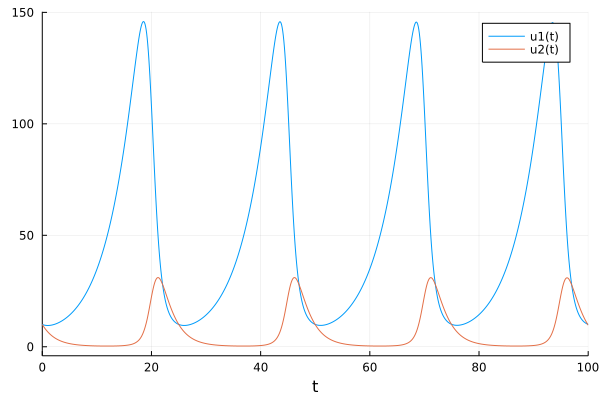

In [59]:
# Simple example using the Lotka-Volterra equations 

function lotka_volterra(xv, p, t)
    x, y = xv
    α, β, γ, δ = p

    dx = x * (α - β * y)
    dy = -y * (γ - δ * x)

    return [dx, dy]
end

xv0 = [10.0, 10.0]
tspan = (0.0, 100.0)
p = [0.2, 0.03, 0.5, 0.01]
prob = ODEProblem(lotka_volterra, xv0, tspan, p)
sol = solve(prob)

plot(sol)

## Modelling the Furuta pendulum
Now, based on the [report by Magnus Gäfvert](./papers/furuta_modelling.pdf), you should implement corresponding dynamics function for the Furuta pendulum. Section 5 of the report contains the ODE-model to use. 

We saw in the previous lab that the dynamics between motor voltage and current were fast (compared to the mechanical time constants), and so we will approximate the dynamics between voltage and torque by a static gain (since the torque is directly proportional to the current).

The input torque will later be defined using a function `u(t)`, that you can call from within the function used by the ODE solver to compute the time derivatives.

Note that the model in the report differs slightly from your Furuta pendulum. The report assumes there is a point mass at the end of the pendulum arm, and it also assumes that it is possible to apply external torque on both joints of the pendulum. This makes your system a special case of the one in the report. Write a function that DifferentialEquations.jl will accept, that includes the parts of the the model in the report that are relevant to your system.

In [ ]:
# A: Furuta dynamics function

alpha = J + (M + 1/3 * ma + mp) * (la ^ 2)
beta = (M + 1/3*mp) * (lp^2)
gama = (M+1/2*mp)*lp*la
delta = (M=1/2*mp)*g*lp

phi = read(furuta.base_angle)
dphi = phid = phi/t
dphid = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)) * (beta*gama((sin(theta))^2-1)*sin(theta)*phid^2 - 2*beta^cos(theta)*sin(theta)*thetad*phid + beta*gama*sin(theta)*thetad^2 - gama*delta*cos(theta)*sin(theta))

theta = read(furuta.arm_angle)
dtheta = thetad = theta/t
dthetad = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)) *(beta*gama*(alpha+beta*(sin(theta))^2)*cos(theta)*sin(theta)*phid^2 + 2*beta*gama*(1-(sin(theta))^2)*sin(theta)*thetad*phid - gama*cos(theta)*sin(theta)*thetad^2 + delta(alpha+beta*(sin(theta))^2)sin(theta)-gama*cos(theta)*tau)






The Furuta pendulum model in the report has torque as input, while voltage is the input of our physical system. In the first lab we used the motor model

$$
u=Ri + L\frac{di}{dt}+k_v\frac{d\varphi}{dt}
$$

and concluded that its time constant is fast, so that for our purposes we can approximate it with the static relation $u=Ri$. We also know that the current is proportional to the torque through $\tau=K_a i$, and we will therefore use the actuation model $\tau=K_a/R u$. Let us introduce the parameter $K_u=K_a/R$ and include it in the dynamics function, now using `u(t)` as an input in voltage instead of torque.

In [ ]:
# A: Furuta dynamics with simple motor model


alpha = J + (M + 1/3 * ma + mp) * (la ^ 2)
beta = (M + 1/3*mp) * (lp^2)
gama = (M+1/2*mp)*lp*la
delta = (M=1/2*mp)*g*lp

phi = read(furuta.base_angle)
dphi = phid = phi/t
dphid = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)) * (beta*gama((sin(theta))^2-1)*sin(theta)*phid^2 - 2*beta^cos(theta)*sin(theta)*thetad*phid + beta*gama*sin(theta)*thetad^2 - gama*delta*cos(theta)*sin(theta))

theta = read(furuta.arm_angle)
dtheta = thetad = theta/t
dthetad = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)) *(beta*gama*(alpha+beta*(sin(theta))^2)*cos(theta)*sin(theta)*phid^2 + 2*beta*gama*(1-(sin(theta))^2)*sin(theta)*thetad*phid - gama*cos(theta)*sin(theta)*thetad^2 + delta(alpha+beta*(sin(theta))^2)sin(theta)-gama*cos(theta)*tau)





### Initial parameters
We supply you with some initial parameter values here, that were provided by the manufacturer of the pendulum. Some, such as the masses and lengths were measured on the actual unit, while for example the moment of intertia was computed numerically from the CAD model. With these you can now do a simple simulation and plot the resulting motion of the Furuta pendulum. Later you will try to improve on these estimates to make the model act more like the actual processes.

In [10]:
# Define the physical parameters of the pendulum
J = 1.54e-4 # Combined moment of inertia [kg*m^2]
M = 0 # Mass of ball at the end of the pendulum (that we don't have) [kg]
ma = 0 # Mass of the base arm (zero since we have a circular symmetrical base, not an arm) [kg]
mp = 5.44e-3 # Mass of the pendulum arm [kg]
la = 4.3e-2 # Base radius [m]
lp = 6.46e-2 # Arm length [m]

0.0646

In addition, we use values from the motor datasheet for $K_u$:

In [11]:
# Motor model
R = 0.13 # [Ohm]
Ka = 0.03 # [N*m*Ohm/V]
Ku=Ka/R # Input gain [N*m/V]

0.23076923076923075

And to define the simplified parameters used in the report, we also need that $g=9.81$

In [12]:
g = 9.81 # [m/s^2]

# 
α = J+(M+ma/3+mp)*la^2 # [kg*m^2]
β = (M+mp/3)*lp^2 # [kg*m^2]
γ = (M+mp/2)*la*lp # [kg*m^2]
δ = (M+mp/2)*g*lp # [kg*m^2/s^2]

0.0017237347200000004

Simulate your model with the pendulum hanging straight down as the initial condition. Define `u(t)=0` as the control signal. What would you expect from the simulation? Try to add a small constant control signal. Do the same experiments on the real furuta and compare the results.

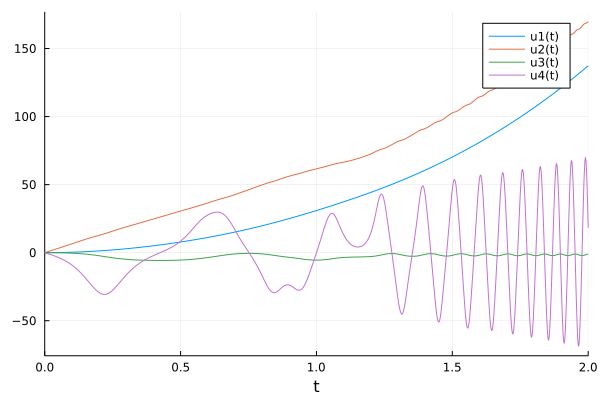

In [68]:
# A: Simulated and real experiments
function lotka_volterra(xv0,p,t)
    # A: Furuta dynamics with simple motor model
    
    phi,dphi,theta,dtheta = xv0
    alpha, beta, gama, delta, J,M,ma,mp,la,lp,R,ka,ku,g,tau= p
    phid = phi
    thetad =theta
    
    dphid = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)^2) * (beta*gama*((sin(theta))^2-1)*sin(theta)*(phid^2) - 2*beta^2*cos(theta)*sin(theta)*thetad*phid + beta*gama*sin(theta)*(thetad^2) - gama*delta*cos(theta)*sin(theta) + beta*tau)
    
    dthetad = 1/(alpha*beta - gama^2+(beta^2+gama^2)*sin(theta)^2) *(beta*(alpha+beta*(sin(theta))^2)*cos(theta)*sin(theta)*phid^2 + 2*beta*gama*(1-(sin(theta))^2)*sin(theta)*thetad*phid - gama^2*cos(theta)*sin(theta)*thetad^2 + delta*(alpha+beta*(sin(theta))^2)*sin(theta)-gama*cos(theta)*tau)

    return [dphi,dphid,dtheta, dthetad]
end

tau= 0.01 
φ=0
dot_φ=0
θ=0
dot_θ=0
xv0 = [φ,dot_φ,θ,dot_θ]
tspan = (0.0, 2)
p = [α, β, γ, δ,J,M,ma,mp,la,lp,R,Ka,Ku,g,tau]
prob = ODEProblem(lotka_volterra, xv0, tspan, p)
sol = solve(prob)

plot(sol)








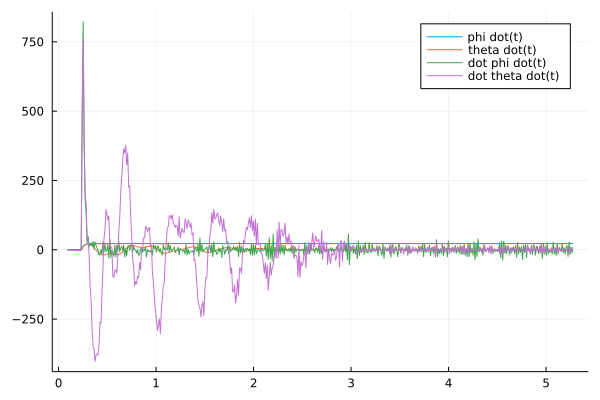

In [105]:
using FurutaPendulums, Plots, DelimitedFiles, ControlSystems
furuta = FurutaPendulum()
# Constants
h = 0.01  # Sampling time
u = 3.0
#A:

# Initialize variables
prev_φ = read(furuta.base_angle)
prev_θ = read(furuta.arm_angle)
start_time=last_time=periodic_wait(furuta,0.0,0.0)

# Initialize arrays for recording
φ_values = Float64[]
θ_values = Float64[]
φdot_values = Float64[]
θdot_values = Float64[]
dφd_values = Float64[]
dθd_values = Float64[]

time_values = Float64[]

# Function to compute finite-difference estimates of derivatives
function measure(furuta, prev_state, h)
    φ = read(furuta.base_angle)
    θ = read(furuta.arm_angle)
    last_time = periodic_wait(furuta, prev_state[5], h)
    φdot = (φ - prev_state[1]) / h  # Finite difference approximation of φdot
    θdot = (θ - prev_state[3]) / h  # Finite difference approximation of θdot
    if abs(φ - prev_state[1]) > π
        φ_ = φ - 2π * sign(φ - prev_φ)
        φdot = (φ_ - prev_state[1]) / h
    end
    if abs(θ - prev_state[3]) > π
        θ_= θ - 2π * sign(θ - prev_θ)
        θdot = (θ_ - prev_state[3]) / h
    end
    dφd = (φdot - prev_state[2]) / h
    dθd = (θdot - prev_state[4]) / h
    
    return (φ, φdot, θ, θdot, last_time, dφd, dθd)
end

# Initial state
state = measure(furuta, (prev_φ, 0.0, prev_θ, 0.0, start_time, 0.0, 0.0), h)

# Loop to record and plot
for k = 1:round(5 / h)    
    push!(φ_values, state[1])
    push!(θ_values, state[3])
    push!(φdot_values, state[2])
    push!(θdot_values, state[4])
    push!(dφd_values, state[6])
    push!(dθd_values, state[7])
    time_values=[time_values;state[5]-start_time] 
    
    control(furuta, u)
    
    state = measure(furuta, state, h)
    prev_φ = state[1]
    prev_θ = state[3]
end
control(furuta, 0.0)
# Plotting
#plot(time_values, φ_values, label="phi(t)", xlabel="Time (t)", ylabel="Angle (rad)", title="Angle Measurements")
#plot!(time_values, θ_values, label="theta(t)")


plot(time_values, φdot_values, label="phi dot(t)")
plot!(time_values, θdot_values, label="theta dot(t)")
plot!(time_values, dφd_values, label="dot phi dot(t)")
plot!(time_values, dθd_values, label="dot theta dot(t)")

How do the simulated and real experiments differ, and can you explain why?

A: 

### Linearized models
If we successfully manage to balance the pendulum, we will confine it to a small region of state space, corresponding to the arm being upward, the base almost still and the angular velocities of the base and arm being small. Use the nonlinear model to show that the upward and downward positions constitue stationary (equilibrium) points.

A: 

Now linearize the pendulum dynamics around both the upward and downward stationary points, and implement the linearized state space dynamics as you have already done for the nonlinear case. Try performing the linearization yourself, rather than just copying the linearized model from the report. (But use the report to verify your result!).

Hint: The linearized models should be on the form
$$
\dot{x}=
\begin{pmatrix}
0&1&0&0\\
0&0&*&0\\
0&0&0&1\\
0&0&*&0
\end{pmatrix}x+
\begin{pmatrix}
0\\
*\\
0\\
*
\end{pmatrix}u,
$$
where $x=[\phi\ \dot{\phi}\ \theta\ \dot{\theta}]^\top$, and where $*$ needs to be replaced by expressions in the physical parameters of the system.

Implement the dynamics for the lower position, $\theta=\pi$, and don't forget that `u(t)` is the voltage, so we have (according to our simplified motor model) that $\tau=K_u u(t)$.


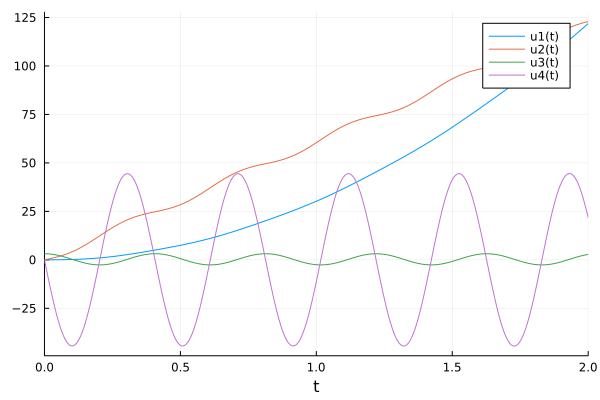

In [69]:
# A: Functions for the linearized dynamics
function linear(x_dot,x, p, t)
    param1, param2, param3, param4,u = p
    
    A = [0 1 0 0;
         0 0 param1 0;
         0 0 0 1;
         0 0 param2 0]

    B = [0;param3; 0; param4]

    x_dot .= A * x + B * u
    
    dphi,dphid,dtheta, dthetad = x_dot
    return [dphi,dphid,dtheta, dthetad]
end

# 定义初始条件
φ=0
dot_φ=0
θ= π
dot_θ=0

xv0 = [φ, dot_φ, θ, dot_θ]

final_time=10.0

param1=-δ*γ/(α*β-γ^2)
param2=-α*δ/(α*β-γ^2)
param3=β/(α*β-γ^2)
param4=γ/(α*β-γ^2)
u= 0.01

# 定义参数向量
p = [param1, param2, param3, param4,u]

# 定义时间范围
tspan = (0.0, 2.0)

# 创建ODE问题
prob = ODEProblem(linear, xv0, tspan, p)

# 解决ODE问题
sol = solve(prob)
plot(sol)

# 可以通过索引 x_values 获取状态向量 x 在不同时间点的值

Next, compare simulations of the nonlinear and linear dynamics. Remember that the linearized model operates around its linearization point, which it has as zero. So the initial condition needs to be handled separately for the linearized and non-linear problems, and the output will also need to be interpreted in relation to this.

How are they similar? How do they differ? Is everything as you would expect?

In [ ]:
# A: Simulation comparison 

### Minimal realization?
Looking at the state space dynamics it is natural to wonder if there exists any system with fewer states, but with equivalent input-output dynamics. For the linearized model this question can be answered by investigating what subspaces of the state space that are observable and reachable. If the entire state space is both observable and reachable, the state space model constitutes a minimal realization, and no states can be removed. Unless you remember these topics from previous courses, read about observability and reachability in the book by Åström and Murray linked from the course Canvas page, and check whether your state spaces models constitute minimal realization. Spend a moment thinking about what you expect the answer to be before implementing any computations.

In [71]:
# A: Code to check for observability and reachability in the linear model

param1=-δ*γ/(α*β-γ^2)
param2=-α*δ/(α*β-γ^2)
param3=β/(α*β-γ^2)
param4=γ/(α*β-γ^2)

A = [0 1 0 0;
     0 0 param1 0;
     0 0 0 1;
     0 0 param2 0]

B = [0;param3; 0; param4]

# Observability
C = [1 0 0 0]
Q_o = [C;
       C * A;
       C * A^2;
       C * A^3]
rank_Q_o = rank(Q_o)
println("rank(Q_o) = $rank_Q_o")

# Reachability
S_r = [B A * B A^2 * B A^3 * B]
rank_S_r = rank(S_r)
println("rank(S_r) = $rank_S_r")

rank(Q_o) = 4
rank(S_r) = 4


### Adding a friction model
As you have likely already observed, the ideal friction-free model will not stop moving (unless explicitly slowed down using the control signal), while the real pendulum will always come to rest after some time if no control signal is provided. And if you provide a constant input, the base angular velocity will keep increasing, rather than leveling out. This is because energy dissipates as heat through friction in the joints, and beause we have not included the back-EMF part of the motor model.

If one has a good friction model, it enables friction compensation in the controller design. However, obtaining accurate friction models is in general quite intricate, as friction can have many different characteristics. For example, you can try to slowly step up the control signal in a staircase fashion to notice that the base will first tart to turn once some minimal control signal level has been reached. This is due to a type of friction called stiction.

Here, we will model viscous friction, being friction where the friction force is negatively proportional to the angular velocity of the rotating joint. We have two joints, and will therefore need two parameters to model the friction. For the base joint, the friction model will also account for the back-EMF. 
What are the SI units of the friction coefficients?

A:

Now create versions of your full nonlinear model, as  well as the linearized model where $\theta=\pi$, that include a friction model. Vary the friction coefficients in simulation and verify that the behaviour is as expected. Hint: first figure out in what elements of the the linearized system matrices the friction model will appear.

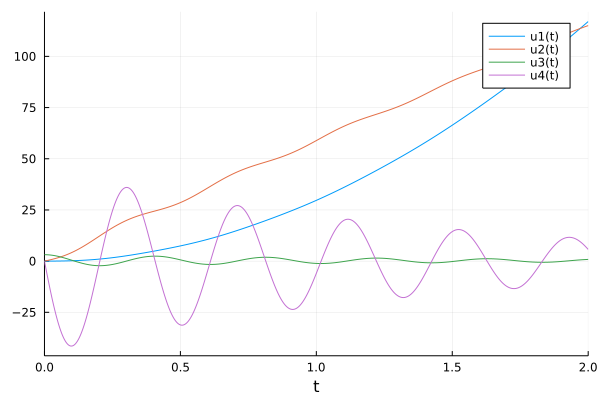

In [79]:
# A: Functions for the linearized dynamics
function linear(x_dot,x, p, t)
    param1, param2, param3, param4, param5, param6, param7, param8,u = p
    
    A = [0 1 0 0;
         0 param5 param1 param6;
         0 0 0 1;
         0 param7 param2 param8]

    B = [0;param3; 0; param4]

    x_dot .= A * x + B * u
    
    dphi,dphid,dtheta, dthetad = x_dot
    return [dphi,dphid,dtheta, dthetad]
end

# 定义初始条件
φ=0
dot_φ=0
θ= π
dot_θ=0

xv0 = [φ, dot_φ, θ, dot_θ]

final_time=10.0

C = 0.00001

param1=-δ*γ/(α*β-γ^2)
param2=-α*δ/(α*β-γ^2)
param3=β/(α*β-γ^2)
param4=γ/(α*β-γ^2)
param5=-β*C/(α*β-γ^2)
param6=-γ*C/(α*β-γ^2) 
param7=-γ*C/(α*β-γ^2)
param8=-α*C/(α*β-γ^2)
u= 0.01

# 定义参数向量
p = [param1, param2, param3, param4, param5, param6, param7, param8, u]

# 定义时间范围
tspan = (0.0, 2.0)

# 创建ODE问题
prob = ODEProblem(linear, xv0, tspan, p)

# 解决ODE问题
sol = solve(prob)
plot(sol)

## Parameter identification
### Identifiability and input excitation
Identifiying the parameters is a less fancy expression for learning the dynamics of the system. If we define some measure of model fit, we can then optimize it over the model parameters, thus learning their true values. Since we are primarily interested in the pendulum arm angle, a candidate for a such measure would be $\|\theta-\hat{\theta} \|$, where $\theta$ is measured on the real system, and $\hat{\theta}$ is the output of the simulation, when the simulation has the same initial state as the real system and is driven by the same control signal.

Obviously, if we start in the rest state and apply no control signal, we will have $\|\theta-\hat{\theta} \|=0$ no matter what parameter values we choose. This is because we do not excite the system dynamics with our experiment. So we need to think about what experiment to conduct. Particularly, in the presence of noise (and other disturbances) our experiment needs to be such that our measure of model fit is (relatively) sensitive to changes away from the true parameter values, but (relatively) insensitive to the disturbances acting on the system.

### The linearized arm subsystem
Let us begin by estimating parameters of the pendulum arm subsystem. Give the pendulum a little "kick" by applying a control signal pulse, that makes it start oscillating, but keep the pulse amplitude low enough to avoid extensive coupling with the base dynamics: that is, keep the oscillation amplitude low enough for the base not to oscillate too much. Also keep the oscillation low enough for the approximation $\sin\phi\approx\phi$ to be valid, enabling the use of the linearized model.

At this point you should have a linearized model of the arm subsystem with viscous friction on the form $\ddot{\theta}=-a_0\theta-a_1\dot{\theta}$, where $a_0$ and $a_1$ are parameters to be determined. This is the differential equation of a damped harmonic oscillator. Its angular frequency is given by $\omega=\sqrt{a_0-a_1^2/4}$. You can probably derive this expression yourself, or look it up for example [here](https://opentextbc.ca/universityphysicsv1openstax/chapter/15-5-damped-oscillations/).


From the experimental output, pick out the oscillation period, and use it to compute the angular frequency. This is still not sufficient to uniquely determine $a_0$ and $a_1$. To do so, we also need to consider the damping. The damping provides an envelope of the oscillation signal that is determined by the exponential decay $\exp(-ta_1/2)$. Picking out the peaks from your experimental data, performing taking the logarithm of their magnitude, and fitting a line of the form $kt+m$ (using ordinary least squares), will provide you with $k=-a_1/2$. Now you have all you need to identify the parameters of the arm subsystem.

In [106]:
# A: Code to run experiment and identify parameters

using DataFrames

# 假设dθd_values是你的信号数据

# 设置阈值，以确定峰值
threshold = 50  # 调整阈值以适应你的数据

# 初始化峰值位置的数组
peak_indices = Int[]

# 初始化峰值振幅的数组
peak_values = Float64[]

# 遍历信号数据
for i in 2:length(dθd_values)-1
    if dθd_values[i] > dθd_values[i-1] && dθd_values[i] > dθd_values[i+1] && dθd_values[i] > threshold
        # 如果当前值大于前一个和后一个，并且大于阈值，则被认为是峰值
        push!(peak_indices, i)
        push!(peak_values, dθd_values[i])
    end
end

# 创建DataFrame以存储峰值位置和振幅
peaks_df = DataFrame(Index=peak_indices, Value=peak_values)

# 打印峰值信息
println(peaks_df)


LoadError: ArgumentError: Package DataFrames not found in current path:
- Run `import Pkg; Pkg.add("DataFrames")` to install the DataFrames package.


### The linearized base subsystem
For the base sub-system, let us start with identifying the viscous friction parameter. Unlike the arm subsystem, we can actuate the base directly. Construct a control signal that looks like a staircase, and let each stair be long enough for the angular velocity to stabilize. You now have a number of control signal levels and a number of corresponding base angular velocities. Isolating the base dynamics, your combined friction and back-EMF model will be $\ddot{\varphi} = -K_f\dot{\varphi} + B_2 u$, where $K_f$ models both motor back-EMF and viscous friction. Note that we ignored the $A_{23}$-term here, for now we will set it to zero in the linearized model with the argument that the effect the angle of the pendulum arm must be a lot smaller than the effect of the motor ($B_2$) and friction ($K_f$) terms. 

Set up a linear regression problem that gives you an estimate of $K_f$ given $B_2$. $B_2$ in turn can be calculated using the linearized $B$-matrix and the given parameters. Incorporate it in your pendulum model.

In [ ]:
# A: Idendification of base joint viscous friction

phidotdot = -Kf phidot + B2 u = 0 => Kf = B2 * [phidot0 phidot1 ...]\[u0 u1 u2 ...]



### The control signal model
From previous experiments we have identified the system matrix $A$, and are now left with determining the input matrix $B$.

Within the linearized model(s), the control signal provides two terms contributing to $\dot{\phi}$ and $\dot{\theta}$. But did we not mention previously that there is no external torque acting on the arm? How would you explain the contribution to $\dot{\theta}$?

A: 

Start out with the $B$ matrix corresponding to the initial parameter values you obtained further above. Simulate the system close to the downward equilibrium where the linearized model is a valid approximation. Manually adjust the relevant elements of the $B$ matrix to find ones that produce as good fit as possible.

In [ ]:
# A: Manual identification of B matrix

## Summary
By now you have a nonlinear model of the pendulum with parameter values that were obtained by the manufacturer by measuring isolated entities such as lengths and masses, and linearized models, where you have identified parameter values from experimental data. There is likely some visual discrepancy between your model output and experiments. The nice thing with feedback control, as we will see in the final lab, is that it can be robust to such discrepancy (to some extent).  

## Bonus: Direct identification of the nonlinear model

### Learning the control signal model
Would it not be nice to identify the parameters of the nonlinear model directly from a single experiment? In general, identification of nonlinear dynamics from data is tricky, since the model fit functions one would typically use to assess the quality of a model candidate are not convex in the model parameters. This means that it is possible to end up in local minima while searching for the parameters that provide the best fit. And in addition, there is the issue with input excitation not being sufficient in that it either does not excite some part of the dynamics at all, or does so only to an extent that the measurable effects are drowned in noise or other disturbances.

Here we will use the Julia optimization package Optim.jl to automate the search for parameter values that explain experimental data. Optimization lies at the heart of many machine learning techniques, and there are broadly speaking two ways to do it: using global (gradient-free) or local (graident-based) methods. Global methods try to search the entire parameter space without getting stuck in local minima. Local methods use the graident of the function that is being optimized (minimized or maximized) to move towards a local optimum, that may or may not coincide with the global one. Typically local methods are faster, but they can get stuck in local minima (or maxima) if the function being optimized is not convex.

First, head over to the [documentation](https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/) of Optim.jl and familiarize yourself with the package. Then write code that automatically learns the $B$ matrix elements that you manually fit before. Try using [Nelder Mead](https://en.wikipedia.org/wiki/Nelder–Mead_method), which is a simplex type gradient-free optimization method.

In [ ]:
# A: Nelder-mead search for B matrix

### Learning a full nonlinear model
Next, let's familiarize ourselves with a technique that lies at the core of neural network training: [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), or AD for short. What AD does is to compute exact gradients of quite general functions. This is (quite generally) possible as long as the functions are natively implemented, so the AD system has access to their definitions. Automatic differentiation relies on something called dual numbers. They are an extension of the reals in a way similar to how complex numbers are defined, and allow for exact evaluation of function derivatives with very low, in fact $\mathcal{O}(1)$, complexity. This sounds almost magic. You can check out how it works for example by reading this [post from the American Mathematical Socieity](http://www.ams.org/publicoutreach/feature-column/fc-2017-12).

In Julia thera are several AD packages, for example [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/stable/). When using Optim.jl, you can enable AD of your cost function as illustrated at the bottom of [this example](https://julianlsolvers.github.io/Optim.jl/stable/#user/gradientsandhessians/).

We will use a quadratic cost function here: $J(p)=\|\theta-\hat{\theta}\|_2^2$, where $p$ is the vector of parameters that we want to minimize. To evaluate the cost function, you first need to ensure that your simulation evaluates at the instances corresponding to those for which you sample experimental data in $\theta$. You can do so by explicitly asking DifferentialEquations.jl to solve at particular time instances. Then you need to construct a function that fits the signature of Optim.jl. Finally, you need to set up an optimization problem that optimizes the parameters based on some experiment that you have recorded. To limit the risk of getting stuck in a local minimum far from the optimal solution, you can initialize your search with the parameter values provided further above.

Note that it can be a bit tricky to get this to work in real life. It is fun if you make it work, but it's definitely not needed to pass the lab. Particularly, it is a good idea to start with just learning one parameter to verify that it works, rather than jumping directly at the full problem.

In [ ]:
# A: Code for learning the nonlinear dynamics using AD

### Sensitivity analysis
The [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix) of $J(p^*)$ at the identified minimum $p^*$, being a generalization of the scalar second derivative, conveys information of the curvature of the cost function there. A large curvature means that $J$ changes more abruptly when we make a small deviation from $p^*$. Performing a singular value decomposition of the Hessian will reveal the sensitivity to changes in the principal parameter space diretions (linear combination of the individual parameters). The direction of highest certainty is defined by the singular vector associated with the smallest singular value of the Hessian, and vice versa. In particular, the condition number of the Hessian is the fraction between the largest and the smallest singular value. If the condition number is large, it is said that the Hessian is ill-conditioned. This means that there is some direction in parameter space that is much more sensitive to perturbations than some other. You can use AD to compute the Hessian at the optimum and compare its conditioning (or full SVD) across some different experiments. In general, experiments with poorer input excitation should result in Hessians with larger condition numbers.

In [ ]:
# A: Investigation of local sensitivy using the cost Hessian